In [1]:
# Built-in modules
import os
import math
import time
from multiprocessing import Pool, cpu_count
from scipy.interpolate import griddata
import uuid 
# Third-party modules
import numpy as np
import matplotlib.pyplot as plt
import imageio
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import qutip
from qutip import *
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output, display, update_display, HTML
import PIL
from typing import List
# Specific functions/classes from third-party library 
from scqubits import *  # consider importing specific functions/classes
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output,  HTML
import uuid
import os
import imageio
import qutip as qt

import math
import scqubits

In [2]:
import math
import numpy as np
def generate_single_mapping(H_with_interaction_no_drive,
                            OVERLAP_THRESHOLD = 0) -> np.ndarray:
    """
    Returns a dictionary like {(0,0,0):0,(0,0,1):1}
    I use this function because I can adjust the OVERLAP_THRESHOLD.

    H_with_interaction_no_drive should be in LC basis (the dimensions shoulld be product-like)
    """
    evals, evecs = H_with_interaction_no_drive.eigenstates()
    overlap_matrix = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(evecs)
    product_state_names = []
    dims = H_with_interaction_no_drive.dims[0]
    system_size = len(dims)
    def generate_product_states(current_state, ele_index):
        if ele_index == system_size:
            product_state_names.append(tuple(current_state))
            return
        
        for l in range(dims[ele_index]):
            current_state[ele_index] = l
            generate_product_states(current_state.copy(), ele_index + 1)

    current_state = [0] * system_size
    generate_product_states(current_state, 0)



    total_dim = math.prod(dims)
    dressed_indices_and_overlap = [None] * total_dim
    for dressed_index in range(len(evals)):
        max_position = (np.abs(overlap_matrix[dressed_index, :])).argmax()
        max_overlap = np.abs(overlap_matrix[dressed_index, max_position])
        if (max_overlap**2 > OVERLAP_THRESHOLD):
            overlap_matrix[:, max_position] = 0
            dressed_indices_and_overlap[int(max_position)] = (dressed_index,max_overlap**2)
        else:
            print(f'max overlap^2 {max_overlap**2} below threshold for dressed state {dressed_index} with eval {evals[dressed_index]}')
    product_to_dressed = {}
    product_to_overlap = {}
    for product, dressed_and_overlap in zip(product_state_names,dressed_indices_and_overlap):
        product_to_dressed[product] = dressed_and_overlap[0]
        product_to_overlap[product] = dressed_and_overlap[1]
    return product_to_dressed,product_to_overlap

In [3]:
qubit_levels = 5
osc_levels = 6

q1 =  Fluxonium(EJ = 4.03,
                EC =1.18,
                EL = 0.78,
                flux = 0.5,
                cutoff = 110,
                truncated_dim = qubit_levels)
q2 =  Fluxonium(EJ = 4.34,
                EC =1.13,
                EL = 1.42,
                flux = 0.5,
                cutoff = 110,
                truncated_dim = qubit_levels)



hilbertspace = HilbertSpace([q1, q2])

JC = 0.28

hilbertspace.add_interaction(
    g_strength=JC, op1=q1.n_operator, op2=q2.n_operator, add_hc=False
)
hilbertspace.generate_lookup()

product_to_dressed,product_to_overlap = generate_single_mapping(hilbertspace.hamiltonian())
product_to_dressed, product_to_overlap

({(0, 0): 0,
  (0, 1): 2,
  (0, 2): 5,
  (0, 3): 10,
  (0, 4): 16,
  (1, 0): 1,
  (1, 1): 3,
  (1, 2): 6,
  (1, 3): 11,
  (1, 4): 18,
  (2, 0): 4,
  (2, 1): 7,
  (2, 2): 12,
  (2, 3): 17,
  (2, 4): 21,
  (3, 0): 8,
  (3, 1): 9,
  (3, 2): 15,
  (3, 3): 19,
  (3, 4): 23,
  (4, 0): 13,
  (4, 1): 14,
  (4, 2): 20,
  (4, 3): 22,
  (4, 4): 24},
 {(0, 0): 0.9999604545364734,
  (0, 1): 0.999623136268469,
  (0, 2): 0.9994724557211608,
  (0, 3): 0.9985083511854078,
  (0, 4): 0.9988103571045959,
  (1, 0): 0.9996341839299844,
  (1, 1): 0.9996249195933871,
  (1, 2): 0.6604736384322737,
  (1, 3): 0.9389558096475545,
  (1, 4): 0.7650252807005036,
  (2, 0): 0.99962744614804,
  (2, 1): 0.6601983499338963,
  (2, 2): 0.932274406831842,
  (2, 3): 0.7429007882607112,
  (2, 4): 0.9870356627607155,
  (3, 0): 0.9984801972609137,
  (3, 1): 0.9903176594815352,
  (3, 2): 0.8241285989816187,
  (3, 3): 0.5898929975878887,
  (3, 4): 0.8922568822846586,
  (4, 0): 0.9992580254263076,
  (4, 1): 0.8481384319278424,
  (

# TODO: plot the energy-level diagram

In [4]:
n_1 = hilbertspace.op_in_dressed_eigenbasis(op=q1.n_operator)
n_2 = hilbertspace.op_in_dressed_eigenbasis(op=q2.n_operator)
n_1 = qutip.Qobj(n_1[:, :])
n_2 = qutip.Qobj(n_2[:, :])


(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
diag_dressed_hamiltonian = qutip.Qobj(diag_dressed_hamiltonian[:, :])



In [11]:
def transition_frequency(s0: int, s1: int) -> float:
    return abs(
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )

omega_2 = transition_frequency(product_to_dressed[(0,0)], product_to_dressed[(0,1)])
# omega_2  = q2.eigenvals(evals_count = 2)[1]-q2.eigenvals(evals_count = 2)[0]



# Using the method in appendix of selective darkening 2010 paper doesn't work here. Maybe it's because we driven operators are not the same
# omega_1  = q1.eigenvals(evals_count = 2)[1]-q1.eigenvals(evals_count = 2)[0]
# theta_1 = math.atan(2*JC/(omega_2+omega_1))/2
# theta_2 = math.atan(2*JC/abs(omega_2-omega_1))/2

# amplitude_ratio = math.sin(theta_1+theta_2)/math.cos(abs(theta_1-theta_2))
# omega_1, omega_2, amplitude_ratio

(0.9930697411080951, 0.9933460597921107)

# Optimize for the selective darkening relative amplitude and relative phase

In [9]:

def get_sum_of_gg_population(amplitude_ratio,relative_phase):
    epsilon_A = 1
    epsilon_B = epsilon_A * amplitude_ratio

    tg = 50 # ns

    def drive_coeff_A(t: float, *args: dict) -> float:
        return np.cos(2 * np.pi *omega_2 * t)
        
    def drive_coeff_B(t: float, *args: dict) -> float:
        return np.cos(2 * np.pi *omega_2 * t+relative_phase)


    H_with_drive = [
        diag_dressed_hamiltonian,
        [2 * np.pi * epsilon_A * n_1  , drive_coeff_A], 
        [-2 * np.pi * epsilon_B * n_2 , drive_coeff_B]
    ]


    product_states = [(0, 0)]
    idxs = [product_to_dressed[(s1, s2)] for (s1, s2) in product_states]
    qutip_states = [qutip.basis(hilbertspace.dimension, idx) for idx in idxs]

    tlist = np.linspace(0, tg, tg*2)
    result = qutip.mesolve(
        H = H_with_drive,
        rho0 = qutip.basis(hilbertspace.dimension, product_to_dressed[(0, 0)]),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states],
    )
    gg_expectations = result.expect[0]
    return sum(gg_expectations)



from qiskit.algorithms.optimizers import SLSQP

optimizer = SLSQP(maxiter=1000, tol=1e-6)

def objective(params):
    amplitude_ratio, relative_phase = params
    return -get_sum_of_gg_population(amplitude_ratio, relative_phase)

result = optimizer.minimize( fun=objective, x0=[0.25, np.pi], bounds=[(0.0, 0.5), (0, 2*np.pi)])

amplitude_ratio, relative_phase = result.x
opt_value = -result.fun

print(f"Optimal amplitude ratio: {amplitude_ratio}")
print(f"Optimal relative phase: {relative_phase}")
print(f"Optimal value: {opt_value}")


Optimal amplitude ratio: 0.006871536310063344
Optimal relative phase: 3.1413321845064743
Optimal value: 97.19779537680266


10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.07s. Est. time left: 00:00:00:00
30.0%. Run time:   0.10s. Est. time left: 00:00:00:00
40.0%. Run time:   0.14s. Est. time left: 00:00:00:00
50.0%. Run time:   0.18s. Est. time left: 00:00:00:00
60.0%. Run time:   0.21s. Est. time left: 00:00:00:00
70.0%. Run time:   0.25s. Est. time left: 00:00:00:00
80.0%. Run time:   0.29s. Est. time left: 00:00:00:00
90.0%. Run time:   0.32s. Est. time left: 00:00:00:00
Total run time:   0.36s
10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.0%. Run time:   0.12s. Est. time left: 00:00:00:00
40.0%. Run time:   0.16s. Est. time left: 00:00:00:00
50.0%. Run time:   0.21s. Est. time left: 00:00:00:00
60.0%. Run time:   0.25s. Est. time left: 00:00:00:00
70.0%. Run time:   0.29s. Est. time left: 00:00:00:00
80.0%. Run time:   0.34s. Est. time left: 00:00:00:00
90.0%. Run time:   0.39s. Est. time left: 00:00:00:00
Tota

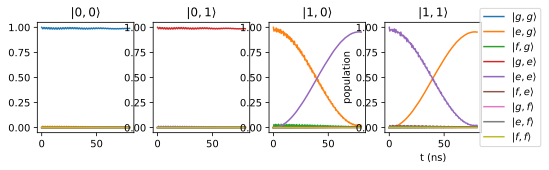

In [10]:

import numpy as np
import qutip
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive

epsilon_A = 0.6
epsilon_B = epsilon_A * amplitude_ratio

tg = 80 # ns

def drive_coeff_A(t: float, *args: dict) -> float:
    return np.cos(2 * np.pi *omega_2 * t)
    
def drive_coeff_B(t: float, *args: dict) -> float:
    return np.cos(2 * np.pi *omega_2 * t+relative_phase)


H_with_drive = [
    diag_dressed_hamiltonian,
    [2 * np.pi * epsilon_A * n_1  , drive_coeff_A], 
    [-2 * np.pi * epsilon_B * n_2 , drive_coeff_B]
]


product_states = [(0, 0), (1, 0), (2,0), (0, 1), (1, 1), (2,1),(0,2),(1,2),(2,2)]
idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
qutip_states = [qutip.basis(hilbertspace.dimension, idx) for idx in idxs]

tlist = np.linspace(0, tg, tg*2)
results = []
for dressed_idx in [product_to_dressed[product_indices] for product_indices in  [(0, 0),(0, 1), (1, 0),  (1, 1)]]:
    temp = qutip.mesolve(
        H = H_with_drive,
        rho0 = qutip.basis(hilbertspace.dimension, dressed_idx),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states],
        # options=qutip.Options(store_states=True),
        progress_bar = True
    )
    results.append(temp)


dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
titles = [(0, 0),(0, 1), (1, 0), (1, 1)]

for i in range(4):
    for idx, res in zip(idxs, results[i].expect):
        product_state = product_states[idxs.index(idx)]
        q1_state = dictionary[product_state[0]]
        q2_state = dictionary[product_state[1]]
        axes[i].plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([q1_state,q2_state]))))
    q1_start = titles[i][0]
    q2_start = titles[i][1]
    axes[i].set_title(r"$|%s\rangle$" % (str(",".join([str(q1_start),str(q2_start)]))))

axes[3].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))

plt.ylabel("population")
plt.xlabel("t (ns)")
max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
for col in [0,1,2,3]:
    ymin, ymax = axes[col].get_ylim()
    xmin, xmax = axes[col].get_xlim()
    if ymax > max_y_range:
        max_y_range = ymax
    if ymin < min_y_range:
        min_y_range = ymin
    if xmax > max_x_range:
        max_x_range = xmax
    if xmin < min_x_range:
        min_x_range = xmin
for col in [0,1,2,3]:
    axes[col].set_ylim(min_y_range, max_y_range)
    axes[col].set_xlim(min_x_range,max_x_range) 
# plt.yscale('log')
plt.show()


